In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
from keras.layers import Input
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, ReLU, concatenate, MaxPool2D, AvgPool2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [23]:
# ds_train, ds_info = tfds.load('cifar10', split='train', shuffle_files=True, as_supervised=True, with_info=True)
# ds_test = tfds.load('cifar10', split='test', shuffle_files=True, as_supervised=True)
# #tfds.show_examples(ds_test, ds_info)

# print(ds_info)

In [24]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.uint8), label

# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_test = ds_test.batch(128)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [25]:
train_df = pd.read_csv('train_data.csv',dtype=str)
val_df = pd.read_csv('val_data.csv',dtype=str)
test_df = pd.read_csv('test_data.csv',dtype=str)

train_df["class"] = train_df["class"].astype(str).astype(float)
val_df["class"] = val_df["class"].astype(str).astype(float)
test_df["class"] = test_df["class"].astype(str).astype(float)


train_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
                                                    directory='',\
                                                    xcol='filename',y_col='class',\
                                                    target_size=(72,72), color_mode='rgb',\
                                                    batch_size=128, class_mode='raw',\
                                                    shuffle=True) #RETURN TO TRUEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
val_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(72,72), color_mode='rgb',\
                                                batch_size=128, class_mode='raw',\
                                                shuffle=True)
test_datagen = ImageDataGenerator(fill_mode = "reflect", data_format = "channels_last")
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(72,72), color_mode='rgb',\
                                                batch_size=128, class_mode='raw',\
                                                shuffle=False)

Found 476 validated image filenames.
Found 2346 validated image filenames.
Found 2950 validated image filenames.


In [26]:
num_classes = 5
input_shape = (32, 32, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

In [27]:
learning_rate = 0.001
weight_decay = 0.00001
batch_size = 32
num_epochs = 2
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [28]:
data_augmentation = keras.Sequential(
    [
        #layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
#data_augmentation.layers[0].adapt(train_generator)

In [29]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [30]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [31]:
# plt.figure(figsize=(4, 4))
# image = x_train[np.random.choice(range(x_train.shape[0]))]
# plt.imshow(image.astype("uint8"))
# plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
# patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

In [32]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [33]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [34]:
model = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay, epsilon = 1e-7, clipnorm = 1
    )

step_size_train = np.ceil(train_generator.n/train_generator.batch_size)
step_size_val = np.ceil(val_generator.n/val_generator.batch_size)

from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
class_weights = dict(enumerate(class_weights))
print(class_weights)

model.summary()



# history = model.fit(
#     ds_train, epochs=1, verbose=1,\
#     validation_data=ds_test,\
#     validation_freq=1
#     )

{0: 5.95, 1: 0.952, 2: 0.43272727272727274, 3: 0.7616, 4: 6.346666666666667}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   0           ['input_2[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 144, 64)     16192       ['patches_1[0][0]']              
               

In [35]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
    )

history = model.fit(
    train_generator, steps_per_epoch=step_size_train, epochs=2, verbose=1,\
    validation_data=val_generator, validation_steps=step_size_val,\
    validation_freq=1#, class_weight=class_weights #class weights break everything and for some reaosn it thinks there are still 10 classes?
    )

Epoch 1/2
4/4 [==============================] - 7s 1s/step - loss: nan - accuracy: 0.0105 - top-5-accuracy: 0.2689 - val_loss: nan - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00
Epoch 2/2
4/4 [==============================] - 3s 1s/step - loss: nan - accuracy: 0.0000e+00 - top-5-accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0000e+00


In [36]:
# model.trainable = False
#model.summary()

In [37]:
# x = model.layers[-2].output
# pred = Dense(5)(x) #didn't have a softmax?
# model_new = Model(inputs = model.input, outputs = pred)
# model_new.summary()

In [38]:
# step_size_train = np.ceil(train_generator.n/train_generator.batch_size)
# step_size_val = np.ceil(val_generator.n/val_generator.batch_size)

# from sklearn.utils import class_weight 
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
# class_weights = dict(enumerate(class_weights))
# print(class_weights)

In [39]:
# model_new.compile(loss='categorical_crossentropy', optimizer=optimizer,\
#               metrics=['categorical_accuracy'])

# checkpoint_filepath = "BCS_CNN\\BCS_CNN_{epoch:0d}.hdf5"
# checkpoint = keras.callbacks.ModelCheckpoint('BCS_CNN\\BCS_CNN_{epoch:0d}.hdf5', monitor='accuracy', verbose=1, save_best_only=True, mode='max', initial_value_threshold = 0.45)
# callbacks_list = [checkpoint]

    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )
# model_new.compile(
#     optimizer=optimizer,
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #had from_logits=True
#     metrics=[
#         keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#         #keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
#     ],
#     )


# history = model_new.fit(
#     train_generator, steps_per_epoch=step_size_train, epochs=1, verbose=1,\
#     validation_data=val_generator, validation_steps=step_size_val,\
#     validation_freq=1, class_weight=class_weights #class weights break everything and for some reaosn it thinks there are still 10 classes?
#     )

    #model.load_weights(checkpoint_filepath)
    # Y_test_hat=model.predict(test_generator)
    # y_test_hat=Y_test_hat.argmax(axis=-1)+2
    # y_test = test_df['class']
    # y_test = [int(i) for i in y_test]

# _, accuracy, top_5_accuracy = model.evaluate(test_generator)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


In [40]:
def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

c:\Users\zacha\anaconda3\envs\ML_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


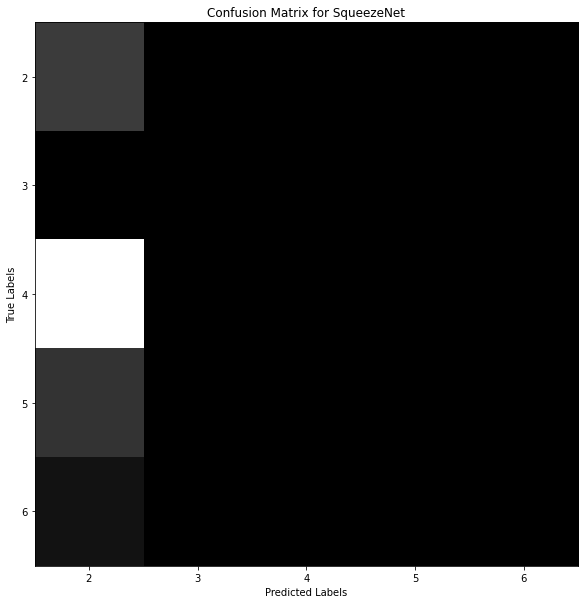

In [41]:
import sklearn.metrics

Y_test_hat=model.predict(test_generator)
y_test_hat=Y_test_hat.argmax(axis=-1)+2

print(y_test_hat[:200])


y_test = test_df['class']
y_test = [int(i) for i in y_test]
print(y_test[:200])

con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()
# acc = tensorflow.keras.metrics.Accuracy()
# acc.reset_state()
# acc.update_state(y_test, y_test_hat)


print('The accuracy of SqueezeNet is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

plt.figure(figsize=(10,10))
plt.imshow(normalize_Xtrain(temp_mat)[0], cmap='gray')
plt.title('Confusion Matrix for SqueezeNet')
plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

print(history.history.keys())
# plt.figure(figsize=(10,10))
# plt.plot(np.arange(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
# plt.plot(np.arange(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
# plt.legend(('Training Accuracy', 'Validation Accuracy'))

#Metrics
precision = sklearn.metrics.precision_score(y_test,y_test_hat, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_test,y_test_hat, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_test,y_test_hat, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(con_matrix)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

KeyError: 'categorical_accuracy'

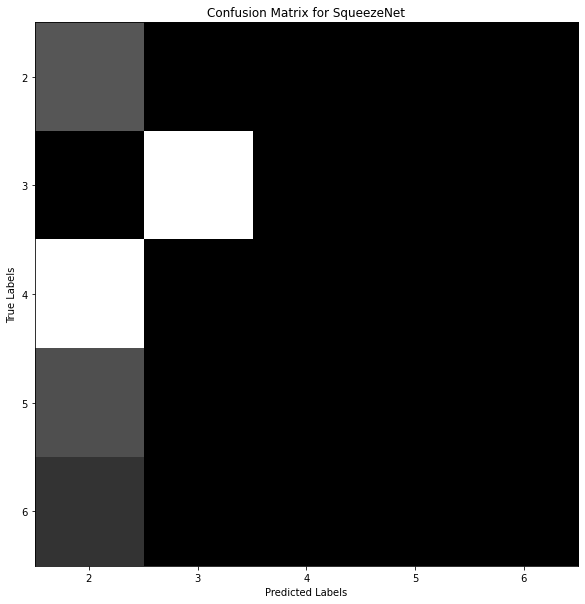

<Figure size 720x720 with 0 Axes>

In [42]:
y_within_1 = []
for i in range(0, len(y_test)):
    if ((y_test_hat[i] == y_test[i]+1) or (y_test_hat[i] == y_test[i]-1) or (y_test_hat[i] == y_test[i])):
        y_within_1.append(y_test[i])
    else:
        y_within_1.append(y_test_hat[i])

print(y_within_1)
print(type(y_within_1[20]))
print(type(y_test[0]))

con_matrix = sklearn.metrics.confusion_matrix(y_test,y_within_1)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()


print('The accuracy of the network model2 is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

plt.figure(figsize=(10,10))
plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
plt.title('Confusion Matrix for SqueezeNet')
plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')


print(history.history.keys())
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(np.arange(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))

#Metrics
precision = sklearn.metrics.precision_score(y_test,y_within_1, average='macro')
print('Model unweighted precision is: ', precision)
precision = sklearn.metrics.precision_score(y_test,y_within_1, average='weighted')
print('Model weighted precision is: ', precision)
print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

recall = sklearn.metrics.recall_score(y_test,y_within_1, average='macro')
print('Model unweighted recall is: ', recall)
recall = sklearn.metrics.recall_score(y_test,y_within_1, average='weighted')
print('Model weighted recall is: ', recall)
print()

f1_score = sklearn.metrics.f1_score(y_test,y_within_1, average='macro')
print('Model unweighted f1_score is: ', f1_score)
f1_score = sklearn.metrics.f1_score(y_test,y_within_1, average='weighted')
print('Model weighted f1_score is: ', f1_score)
print()

MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
print('Model MSE is: ', MSE)


print("Confusion Matrix")
print(con_matrix)